In [75]:
#TODO: исправить всю эту ерунду с сепараторами, сейчас их 3 вида
import pandas as pd
import requests
import numpy as np
import os
from subprocess import Popen, PIPE
from threading import Thread
from multiprocessing import Pool
import sys
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [40]:
#Не теряем ли образцы, у которых почему-то нет первой реплики, зато есть другие?
filterChipEncodeMetadata("../H3K4me1/", '\t', "H3K4me1")

In [44]:
filterByChipRnaCompare("RNA-seq", "H3K4me1", "../H3K4me1/", "../H3K27me3/")

In [45]:
makeChipDataLinksFile("../H3K4me1/", "H3K4me1")

In [48]:
makeRnaDataLinksFile("../H3K4me1/")

In [47]:
addControlAssesions("../H3K4me1/", "H3K4me1")

In [31]:
def filterChipEncodeMetadata(path, sep, name):
    chip = pd.read_csv(path + name + ".csv", sep=sep)
    chip = chip[(chip['Output type'] == 'alignments')&
                (chip['Assembly'] == 'hg19')&
                (chip['File Status'] == 'released')&
                (chip['Biological replicate(s)'] == 1)& 
                (chip['File format'] == 'bam')]
    
    chip.to_csv(path + name + "_filtered.csv", index=False)

In [39]:
#Делается один раз для всех меток(потому что РНК не зависит от меток); уже сделано, лежит в папке H3K27me3
#TODO: Есть технические реплики, но поле заполнено NaN'ами
#TODO: Так же есть одинаковые ткани, но разные эксперименты
def filterRnaEncodeMetadata(path):
    rna = pd.read_csv("../H3K27me3/RNA-seq.csv", sep=';')
    rna = rna[rna['Output type'] == 'gene quantifications']
    rna = rna[rna['Assembly'] == 'hg19']
    rna = rna[rna['File Status'] == 'released']

    rna = rna[(rna['Biological replicate(s)'] == '1')|(rna['Biological replicate(s)'] == '3')]
    #rna[rna['Biosample term name'] == 'K562']['Biological replicate(s)']
    #rna.drop([3199, 3430, 3482], inplace=True)
    #return rna
    rna.to_csv("../H3K27me3/RNA-seq_filtered.csv", sep=';', index=False)

In [43]:
def filterByChipRnaCompare(rna_name, chip_name, chip_path, rna_path):
    chip = pd.read_csv(chip_path + chip_name + "_filtered.csv")
    rna = pd.read_csv(rna_path + rna_name + "_filtered.csv", sep=";")
    
    chipBio = chip['Biosample term id'].tolist()
    rnaBio = rna['Biosample term id'].tolist()
    
    sharedBio = [i for i in chipBio if i in rnaBio]
    
    chip = chip[chip['Biosample term id'].isin(sharedBio)]
    rna[rna['Biosample term id'].isin(sharedBio)].to_csv(chip_path + rna_name + "_filtered_by_biosample.csv", sep=';', index=False)
    
    rnaForChipFiles = []
    for index, row in chip.iterrows():
        rnaForChipFiles.append(rna[rna['Biosample term id'] == row['Biosample term id']].iloc[0]['File accession'])
        
    chip['RNA file assesion'] = rnaForChipFiles
    chip.to_csv(chip_path + chip_name + "_filtered_by_biosample.csv", sep=';', index=False)

In [3]:
rnaData = pd.read_csv("../H3K27me3/RNA-seq_filtered_by_biosample.csv", sep=';')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
rnaData.shape

(111, 45)

In [46]:
def addControlAssesions(chip_path, chip_name):
    chip = pd.read_csv(chip_path + chip_name + "_filtered_by_biosample.csv", sep=';')
    control_assesions = get_control_accession(chip['Experiment accession'])
    chip['Control accession'] = control_assesions
    chip.to_csv(chip_path + chip_name + "_filtered_by_biosample.csv", sep=';', index=False)

In [6]:
def makeChipDataLinksFile(path, chip_name):
    #Отсюда качаем все строки(может быть несколько экспериментов на один biosample - нам только лучше)
    chipData = pd.read_csv(path + chip_name + "_filtered_by_biosample.csv", sep=';')
    chipDataLinks = chipData['File download URL'].tolist()
    
    controlChipDataLinks = map(lambda x: "https://www.encodeproject.org/files/" + x + "/@@download/" + x + ".bam", get_control_accession(chipData['Experiment accession']))
    
    f = open(path + "chipDataLinks.txt", "w")
    for item in chipDataLinks:
        f.write("%s\n" % item)
    f.close()
    
    f = open(path + "controlChipDataLinks.txt", "w")
    for item in controlChipDataLinks:
        f.write("%s\n" % item)
    f.close() 
        

In [7]:
def makeRnaDataLinksFile(path):
    #Отсюда качаем по одному(любому) файлу на biosample - не ясно как выбрать => подходит любой
    rnaData = pd.read_csv(path + "RNA-seq_filtered_by_biosample.csv", sep=';')
    rnaDataLinks = rnaData.drop_duplicates('Biosample term id')['File download URL'].tolist()
    
    f = open(path + "RNA-seq/rnaDataLinks.txt", "w")
    for item in rnaDataLinks:
        f.write("%s\n" % item)
    f.close()

In [8]:
def accession_metadata(acc):
    """
    Returns the metadata for ENCODE accession `acc` (e.g., ENCSR000BJN)
    """
    HEADERS = {'accept': 'application/json'}
    URL = (
        'https://www.encodeproject.org/experiments/{0}/?frame=object'
        .format(acc)
    )
    response = requests.get(URL, headers=HEADERS)
    return response.content

In [9]:
def find_controls(acc):
    """
    The metadata for an accession contains a "possible controls" field. I'm
    taking that to mean there can be multiple controls, so to be safe I'm
    returning a list of them.
    """
    m = pd.read_json(accession_metadata(acc), typ='series')
    c = m['possible_controls']
    return [i.split('/')[2] for i in c]

In [10]:
#Игнорируем реплику, берем первый подходящий контроль с самыми длинными ридами
def get_control_accession(experiment_accessions):
    control_accessions = []
    for r in experiment_accessions:
        url = "https://www.encodeproject.org/report.tsv?type=File&dataset=/experiments/" + find_controls(r)[0] + "/&file_format=bam&frame=object&assembly=hg19&output_type=alignments&status=released"

        meta = pd.read_csv(url, sep="\t", header=1)
        meta = meta.sort_values(by=['Mapped read length'], ascending=False)

        control_accessions.append(meta.iloc[0]['Accession'])
        
    return control_accessions

In [ ]:
#======================================= построим графики ==============================================================

In [76]:
chipData = pd.read_csv("../H3K27me3/H3K27me3_filtered_by_biosample.csv", sep=';')

In [22]:
chipData.head()

,File accession,File format,Output type,Experiment accession,Assay,Biosample term id,Biosample term name,Biosample type,Biosample organism,Biosample treatments,Biosample treatments amount,Biosample treatments duration,Experiment target,Antibody accession,Library made from,Library depleted in,Library extraction method,Library lysis method,Library crosslinking method,Library strand specific,Experiment date released,Project,RBNS protein concentration,Library fragmentation method,Library size range,Biological replicate(s),Technical replicate,Read length,Mapped read length,Run type,Paired end,Paired with,Derived from,Size,Lab,md5sum,dbxrefs,File download URL,Assembly,Platform,Controlled by,File Status,Audit WARNING,Audit INTERNAL_ACTION,Audit NOT_COMPLIANT,Audit ERROR,Control accession,Control reads count,Reads count,norm_factor,RNA file assesion,peaks_count
0,ENCFF591ZGI,bam,alignments,ENCSR000DUE,ChIP-seq,EFO:0001187,HepG2,cell line,Homo sapiens,NaN,NaN,NaN,H3K27me3-human,ENCAB000ANB,DNA,NaN,see document,see document,NaN,False,2011-02-11,ENCODE,NaN,NaN,NaN,1,NaN,NaN,36.0,NaN,NaN,NaN,"ENCFF001FLQ, ENCFF807MUK",260145911,ENCODE Processing Pipeline,87eaeab1ef3f82f4ef6d65d405922a04,NaN,https://www.encodeproject.org/files/ENCFF591ZG...,hg19,NaN,NaN,released,"low read length, mild to moderate bottleneckin...",NaN,"insufficient read depth, control insufficient ...",NaN,ENCFF933EKE,13160528,5324897,0.365466,ENCFF098GZH,18
1,ENCFF947QKE,bam,alignments,ENCSR454ERY,ChIP-seq,UBERON:0001134,skeletal muscle tissue,tissue,Homo sapiens,NaN,NaN,NaN,H3K27me3-human,ENCAB000ASB,DNA,NaN,see document,NaN,NaN,False,2013-07-31,Roadmap,NaN,NaN,NaN,1,NaN,NaN,36.0,NaN,NaN,NaN,"ENCFF807MUK, ENCFF990QOK",394865155,ENCODE Processing Pipeline,56d582d37960e7a73da1d1fa10878123,NaN,https://www.encodeproject.org/files/ENCFF947QK...,hg19,NaN,NaN,released,low read length,NaN,"insufficient read depth, control insufficient ...",NaN,ENCFF820LAK,29727996,26649524,0.676794,ENCFF907CXN,106591
2,ENCFF105XNT,bam,alignments,ENCSR000EXW,ChIP-seq,CL:0000842,mononuclear cell,primary cell,Homo sapiens,NaN,NaN,NaN,H3K27me3-human,ENCAB000ANC,DNA,NaN,see document,see document,NaN,False,2011-10-07,ENCODE,NaN,NaN,NaN,1,NaN,NaN,38.0,NaN,NaN,NaN,"ENCFF000VKC, ENCFF807MUK",1066519930,ENCODE Processing Pipeline,9ea4cf126319f8f9eaf58329431bd262,NaN,https://www.encodeproject.org/files/ENCFF105XN...,hg19,NaN,NaN,released,"low read length, control low read depth",biological replicates with identical biosample,insufficient read depth,NaN,ENCFF918JVX,39409365,25173652,0.443785,ENCFF807JBQ,174194
3,ENCFF573NUY,bam,alignments,ENCSR358KID,ChIP-seq,UBERON:0001871,temporal lobe,tissue,Homo sapiens,NaN,NaN,NaN,H3K27me3-human,ENCAB000ASB,DNA,NaN,see document,NaN,NaN,False,2013-07-31,Roadmap,NaN,NaN,NaN,1,NaN,NaN,36.0,NaN,NaN,NaN,"ENCFF128ZWK, ENCFF807MUK, ENCFF868JZQ, ENCFF96...",144163524,ENCODE Processing Pipeline,db9c4044ae0039b7c22a5722830df9f9,NaN,https://www.encodeproject.org/files/ENCFF573NU...,hg19,NaN,NaN,released,low read length,NaN,"insufficient read depth, control insufficient ...",NaN,ENCFF034RKL,28397603,20525921,0.571110,ENCFF011IOJ,91283
4,ENCFF411ZSE,bam,alignments,ENCSR503YOF,ChIP-seq,UBERON:0002084,heart left ventricle,tissue,Homo sapiens,NaN,NaN,NaN,H3K27me3-human,ENCAB000ADT,DNA,NaN,see document,NaN,NaN,False,2013-07-31,Roadmap,NaN,NaN,NaN,1,NaN,NaN,36.0,NaN,NaN,NaN,"ENCFF807MUK, ENCFF862HOP",683883121,ENCODE Processing Pipeline,d941c475e4887fc1ec60975e5b13e7b8,NaN,https://www.encodeproject.org/files/ENCFF411ZS...,hg19,NaN,NaN,released,"mild to moderate bottlenecking, moderate libra...",NaN,"insufficient read depth, control insufficient ...",NaN,ENCFF925ZDQ,19144870,15036021,0.729420,ENCFF470AAE,21449


In [9]:
chipData['Biosample type'].unique()

array(['cell line', 'tissue', 'primary cell',
       'in vitro differentiated cells', 'stem cell',
       'induced pluripotent stem cell line'], dtype=object)

In [66]:
types = chipData.groupby(['Biosample type'])['Biosample type'].count()

In [23]:
types

Biosample type
cell line                             10
in vitro differentiated cells          6
induced pluripotent stem cell line     1
primary cell                          10
stem cell                              5
tissue                                45
Name: Biosample type, dtype: int64

In [77]:
rcParams['figure.figsize'] = 11.7,8.27
rcParams["patch.force_edgecolor"] = True

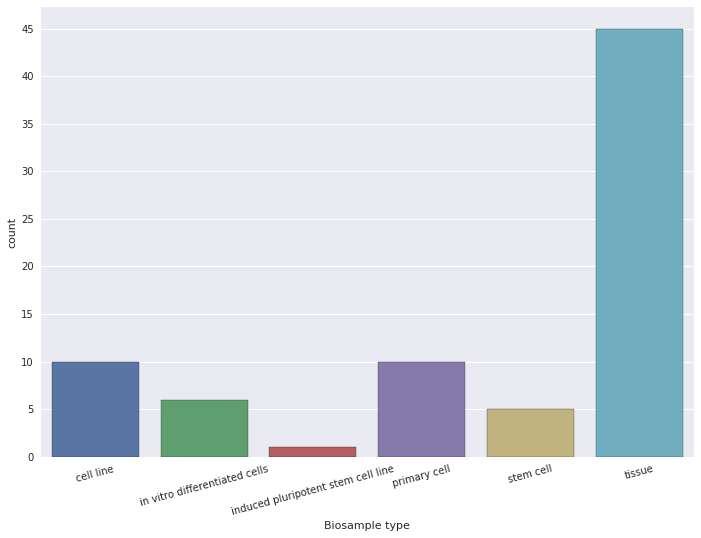

In [68]:
#Можно было сделать countplot, он бы сам все посчитал
ax = sns.barplot(types.index, types.values)
ax.set(xlabel='Biosample type', ylabel='count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.set_yticks(range(0, 50, 5))
plt.show()

In [74]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/ProcessEncodeFiles_biosamples_types_barplot.png", bbox_inches='tight', pad_inches = 0)

In [78]:
sns.set(color_codes=True)

/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


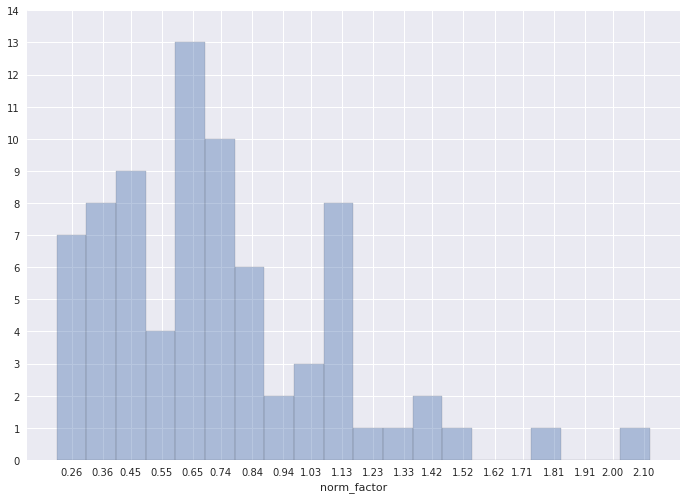

In [79]:
ax = sns.distplot(chipData['norm_factor'], bins=20, kde=False)
ax.set_xticks(np.around(np.linspace(0.26, 2.1, num=20), decimals=2))
ax.set_yticks(range(0, 15))
plt.show()

In [80]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/ProcessEncodeFiles_norm_factors_hist.png", bbox_inches='tight', pad_inches = 0)